# NLP_GoingDeeper | 02. 텍스트의 분포로 벡터화 하기

- **단어의 빈도를 이용하여 텍스트를 표현**하는 방법들과 **텍스트의 분포를 이용해서 텍스트를 토큰화**하는 방법에 대해 배워봅니다. 
- Word2Vec같은 임베딩을 활용한 분산 표현을 학습하는 기법이 대중화되기 이전에 많이 쓰이던 방법들입니다. 
- 텍스트의 분포를 활용하여 텍스트를 벡터화하는 아이디어의 발전사를 통해 기초적 개념을 다져봅니다.
---


### 학습 목차
1. 단어 빈도를 이용한 벡터화
    - Bag of Words
    - Bag of Words 구현
    - DTM과 코사인 유사도
    - DTM의 구현과 한계점
    - TF-IDF
    - TF-IDF 구현하기
2. LSA와 LDA
    - LSA
    - LSA 실습
    - LDA
    - LDS 실습
3. 텍스트 분포를 이용한 비지도 학습 토크나이저
    - 형태소 분석기와 단어 미등록 문제
    - soynlp

In [1]:
! mkdir -p ~/aiffel/topic_modelling/data

# 1. 단어 빈도를 이용한 벡터화
## 1-1. Bag of Words
- 머신러닝 모델은 기계이기 때문에, 텍스트보다는 수치화된 숫자를 더 잘 처리할 수 있습니다. 
- 따라서 기계가 자연어 처리를 원활히 할 수 있도록, 자연어 처리에서는 전처리 과정에서 텍스트를 숫자 벡터로 변환하는 벡터화(Vectorization)이라는 과정을 거치게 됩니다. 
- 벡터화의 방법으로는 크게 (1) 통계와 머신러닝을 활용한 방법, 그리고 (2) 인공신경망을 활용하는 방법 두가지로 나눌 수 있습니다. 
- 오늘은 **통계와 머신러닝을 활용한 벡터화**의 방법을 살펴봅니다.

---
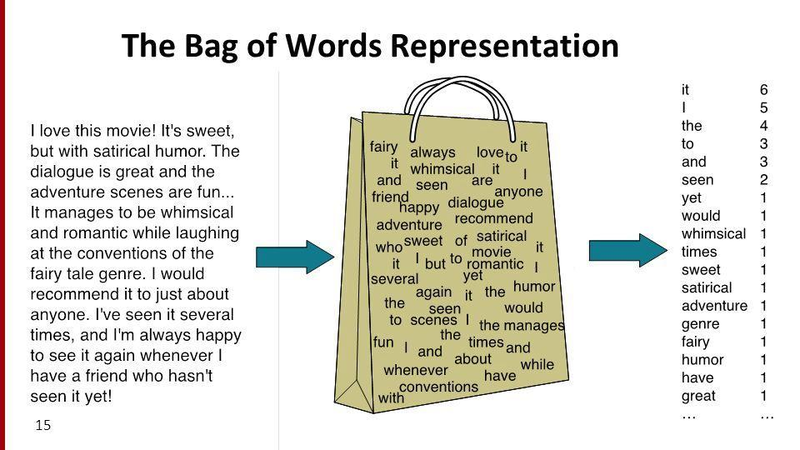
- Bag of Words는 직역하면 '단어들의 가방' 입니다. Bag of Words는 문서를 단어들의 가방으로 가정합니다. 
- Bag of Words 는 자연어 처리(Natural Language Processing)이나 정보 검색(Information Retrieval)에서 쓰이는 매우 간단한 단어 표현 방법으로, **문서 내의 단어들의 분포를 보고 이 문서의 특성을 파악하는 기법**입니다. 줄여서 BoW라고 표기하기도 합니다. 
- 어떤 한 문서에 등장하는 텍스트를 전부 단어 단위로 토큰화(tokenization)합니다. 수 많은 단어들을 전부 가방에 집어넣고 흔들면, 단어의 순서는 무시되고 전부 섞이게 될 것입니다. 또한 중복된 단어들을 제거하지 않고, 빈도를 카운트합니다. 
- 즉 BoW는 단어들의 순서는 무시하고, 단어들의 빈도 정보는 그대로 보존합니다. 


```python
#- BoW 예시
doc1 = 'Avocado likes to watch movies. Walnut likes movies too.'
BoW1 = {"Avocado":1, "likes":2, "to":1, "watch":1, "movies":2, "Walnut":1, "too":1}
```

- 위의 BoW에서 각 key는 단어, 각 value는 각 단어가 주어진 문서에 등장한 횟수입니다.
- BoW 방식으로 문장을 벡터화하면, 어순에 따라 달라지는 의미를 반영하지 못한다는 한계를 가집니다. 

## 1-2. Bag of Words 구현하기
- 텐서플로우 케라스와 사이킷런 라이브러리를 사용해 Bag of Words를 만들어봅니다. 
- Vocabularay는 사전 또는 단어집합이라고 불리는데, 단어장이란 중복을 제거한 단어들의 집합을 말합니다. 이는 Bag of Words와는 다른 개념입니다.
- 어떻게 다를까요 ? 단어장이라는 개념은 Bag of Words를 위해 사용되는 개념이라기보다는, 자연어처리에서 보편적으로 쓰이는 용어입니다. 


### Keras Tokenizer 활용
- 아래 예제에서 단어장의 크기는 10입니다.

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer

sentence = ['Avocado likes to watch movies. Walnut likes movies too! Walnut also likes to watch football games.']

tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentence) #- 단어장 생성
bow = dict(tokenizer.word_counts) #- 각 단어와 각 단어의 빈도를 bow에 저장

print("Bag of Words:", bow) #- bow 출력
print("단어장(Vocabularay)의 크기:", len(tokenizer.word_counts)) #- 중복을 제거한 단어들의 개수

Bag of Words: {'avocado': 1, 'likes': 3, 'to': 2, 'watch': 2, 'movies': 2, 'walnut': 2, 'too': 1, 'also': 1, 'football': 1, 'games': 1}
단어장(Vocabularay)의 크기: 10


### Scikit-learn CountVectorizer 활용
- CountVectorizer의 vector.fit_transform(입력 문장).toarray()로 출력되는 Bag of Words 결과를 보면, 각 단어의 빈도만 출력될 뿐, 어떤 단어의 빈도인지는 나오지 않습니다. 
- vector.vocabularay_를 통해 각 단어에 부여된 인덱스를 학인하면 되는데, 주의할 점은 이 인덱스는 0부터 시작한다는 점입니다. 가령 also의 인덱스는 0입니다. 이때 BoW에 0번째 위치한 값은 1이기에, also의 빈도는 1입니다. likes의 인덱스틑 4인데, BoW에서 4번째 위치한 값은 3이기에 likes의 빈도는 3임을 알 수 있습니다. 

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

sentence = ['Avocado likes to watch movies. Walnut likes movies too! Walnut also likes to watch football games.']

vector = CountVectorizer()
bow = vector.fit_transform(sentence).toarray()

print('Bag of Words:', bow) #- 코퍼스로부터 각 단어의 빈도수를 기록합니다.
print('각 단어의 인덱스:', vector.vocabulary_) #- 각 단어의 인덱스가 어떻게 부여되었는지를 보여줍니다. 
print('단어장(Vocabulary)의 크기:', len(vector.vocabulary_))

Bag of Words: [[1 1 1 1 3 2 2 1 2 2]]
각 단어의 인덱스: {'avocado': 1, 'likes': 4, 'to': 6, 'watch': 9, 'movies': 5, 'walnut': 8, 'too': 7, 'also': 0, 'football': 2, 'games': 3}
단어장(Vocabulary)의 크기: 10


## 1-3. DTM과 코사인 유사도
- DTM(Document-Term Matrix)는 직역하면 문서-단어 행렬입니다. 
- DTM은 여러 문서의 Bag of words를 하나의 행렬로 구현한 것입니다. 
- 다시 말해 **DTM은 각 문서에 등장한 단어의 빈도수를 하나의 행렬로 통합**시킵니다. 
- DTM은 문서를 행으로, 단어를 열로 가지는 행렬이지만, 문헌에 따라서는 열을 문서로 하고, 단어를 행으로 하여 TDM(Term-Document Matrix)라고 부르기도 합니다. 
- 예를 들어, 아래와 같은 3개의 문서가 있다고 가정합니다. 
    문서1 : I like dog
    문서2 : I like cat
    문서3 : I like cat I like cat


- 위 3개의 문서로부터 얻을 수 있는 DTM은 아래와 같습니다. 
- 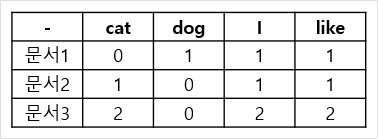
- 각 행은 각 문서를 나타내고, 각 열은 문서 3개의 통합 단어장(Vocabulary)에 있는 단어들로 구성되어 있습니다. 이렇게 구성하면서, 각 행의 많은 값이 0으로 구성되게 됩니다. 
- 이때 각 행을 문서벡터(document vector), 열을 단어 벡터(word vector)라고 부를 수 있는데, 문서의 수가 많아질수록, 통합 단어장의 크기도 커지게 되어서 DTM은 결국 문서 벡터와 단어 벡터 모두 대부분의 값이 0이 되는 성질을 가집니다. 
- 여러 문서들로 DTM을 만들었다면, 이제 BoW로 무엇을 할 수 있을까요? 
- DTM을 사용하여 각 문서들을 비교하고, 각 문서 간 유사도를 구할 수 있게 됩니다. 
- 가장 보편적으로 사용되는 유사도 계산 방법은 [코사인 유사도](https://wikidocs.net/24603)를 살펴봅니다. 
- 위 예시에서, 각 단어에 대한 인덱스를 cat은 0, dog는 1, I는 2, like는 3입니다.

#### 코사인 유사도(Cosine Similarity)
- BoW나 BoW에 기반한 단어 표현 방법인 DTM, TF-IDF 또는 Word2Vec등과 같이 단어를 수치화할 수 있는 방법을 이해했다면, 이러한 표현 방법에 대해서 코사인 유사도를 이용하여 문서의 유사도를 구할 수 있습니다. 
- 코사인 유사도는 두 벡터 간의 코사인 각도를 이용하여 구할 수 있는 두 벡터의 유사도를 의미합니다. 
- 두 벡터의 방향이 완전히 동일한 경우에는 1의 값을 가지며, 90도의 각을 이루면 0, 180도로 반대의 방향을 가지면 -1의 값을 갖게 됩니다.
- 즉 **코사인 유사도는 -1 이상 1이하의 값을 가지며 값이 1에 가까울수록 유사도가 높다고 판단할 수 있습니다.** 이를 직관적으로 이해하면, 두 벡터가 가리키는 방향이 얼마나 유사한가를 의미합니다. 
- 아래 예시에서 문서1과 문서2의 코사인 유사도는 0.67, 문서1과 문서3의 코사인 유사도 또한 0.67인 반면, 문서2와 문서3의 코사인 유사도는 1입니다. 이는 한 문서 내의 모든 단어의 빈도수가 똑같이 증가하는 경우, 기존의 문서와 코사인 유사도 값이 1이 되기 때문입니다. 
- 코사인 유사도는 벡터의 크기가 아닌, 벡터의 방향(패턴)에 초점을 두기 때문에, 벡터의 유사도를 구하는 또 다른 방법인 내적과 차이가 있습니다. 

In [4]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

doc1 = np.array([0,1,1,1]) #- 문서1 벡터
doc2 = np.array([1,0,1,1]) #- 문서2 벡터
doc3 = np.array([2,0,2,2]) #- 문서3 벡터

def cos_sim(A,B):
    return dot(A,B)/ (norm(A)*norm(B))

In [5]:
print(cos_sim(doc1, doc2)) #- 문서1과 문서2의 코사인 유사도
print(cos_sim(doc1, doc3)) #- 문서1과 문서3의 코사인 유사도
print(cos_sim(doc2, doc3)) #- 문서2와 문서3의 코사인 유사도

0.6666666666666667
0.6666666666666667
1.0000000000000002


## 1-4. DTM의 구현과 한계점
- 사이킷런의 CountVectorizer를 이용하여 DTM을 만드는 방법은 앞서 Bag of Words를 만드는 방법과 동일합니다. 단지, 다수의 문서를 입력값으로 주면 되는 것입니다. 
- 다음은 3개의 문서에 대해 DTM을 만드는 과정을 보여줍니다. 
- DTM은 bag of word기반으로 문서를 비교할 수 있는 행렬입니다. 
- 이때 DTM은 두 가지 한계점을 지닙니다. 
    - 문서의 수와 단어의 수가 계속 늘어날수록, 행과 열은 대부분의 값이 0을 가집니다. 이는 저장공간 측면에서 낭비이며, 지나친 차원의 크기는 차원의 저주라는 문제를 발생시킵니다. 
    - 단어의 빈도에만 집중하기 때문에 자주 등장하는 불용어가 유사도 측정에 큰 영향을 미치게 될 수 있습니다. the 와 같이 아무 문서에서나 자주 등장하는 단어들을 문서끼리 비교할 때 실질적인 의미가 없습니다. 
    - 그렇다면 중요한 단어와 중요하지 않은 단어에 가중치를 따로 선별해서 주려면 어떻게 해야 할까요? => TF-IDF

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

corpus = [
    'Avocado likes to watch movies.',
    'Walnut likes movies too!',
    ' Walnut also likes to watch football games.'
]
vector = CountVectorizer()

print(vector.fit_transform(corpus).toarray()) #- 코퍼스로부터 각 단어의 빈도수를 기록합니다. 
print(vector.vocabulary_) #- 각 단어의 인덱스가 어떻게 부여되었는지 보여줍니다. 

[[0 1 0 0 1 1 1 0 0 1]
 [0 0 0 0 1 1 0 1 1 0]
 [1 0 1 1 1 0 1 0 1 1]]
{'avocado': 1, 'likes': 4, 'to': 6, 'watch': 9, 'movies': 5, 'walnut': 8, 'too': 7, 'also': 0, 'football': 2, 'games': 3}


## 1-5. TF-IDF 
- TF-IDF는 각 단어의 중요도를 판단하여 가중치는 주는 방법입니다. 
- TF-IDF는 모든 문서에서 자주 등장하는 단어는 중요도가 낮다고 판단하며, 특정 문서에서만 자주 등장하는 단어는 중요도가 높다고 판단합니다. 
- TF-IDF는 Term Frequency-Inverse Document Frequency의 약자입니다. 한국어로 해석하면 '단어 빈도-역문서 빈도'입니다. '단어의 빈도'와 '문서의 빈도의 역수'를 활용하는 것입니다. 
- TF-IDF는 불용어처럼 중요도가 낮으면서 모든 문서에 등장하는 단어들이 노이즈가 되는 것을 완화해줍니다. 
- 그러나 TF-IDF를 사용하는 것이 DTM을 사용하는 것보다 성능이 항상 뛰어나지는 않습니다. 
- TF-IDF를 사용하기 위해서는 우선 DTM을 만든 뒤 TF-IDF가중치를 DTM에 적용합니다. 
- DTM은 이미 TF(Term Frequency, 단어의 빈도)행렬이기 떄문에, 각 단어에 IDF값을 곱해주면 TF-IDF행렬이 완성됩니다.
- 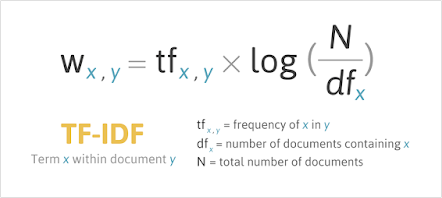
- y : 문서; x : 단어 
- TF는 앞서 설명했듯이, 각 문서에 등장하는 단어의 빈도를 의미하므로 DTM을 만들면 자연스럽게 해결됩니다. 
- 위 수식에서 TF 뒤에 곱해지는 log 항이 IDF 입니다. 
- 예를 들어, 전체 문서의 수가 5개이고 단어 'like'가 문서2에서 200번, 문서 3에서 300번 등장했고, 다른 문서에서는 등장하지 않았습니다. 이때, 단어 like의 IDF는 몇일까요? 
    - IDF를 구하기 위해서는 우선 문서 빈도 D와 전체 문서의 수 N을 이해해야 합니다. 
    - 단어 like의 DF(문서의 빈도)는 2입니다. DF를 구할때는 like가 어떤 문서에서 몇 변 등장했는지는 중요하지 않습니다. 다만 단어 like가 몇 개의 문서에서 등장했는지가 중요합니다. 
    - 전체 문서의 수는 5입니다. 
    - 결과적으로 단어 like의 IDF는 log(5/2)입니다. 
    - 보통 TF-IDF를 지원하는 파이썬 패키지들에서 log는 자연로그를 사용합니다. 
    - 자연로그는 로그의 밑으로 자연상수 e(e = 2.718281...)을 사용하는 로그를 말합니다. 자연로그는 보통 ln으로 표현합니다.
    - 결국 단어 like의 IDF 계산식은 ln(5/2)입니다. 이 값은 0.91629073187 입니다. 

- 문서 2와 문서 3에서의 단어 like의 TF-IDF값은 몇일까요?
    - 문서2애서의 TF는 200, 문서3에서의 TF는 300이었습니다.
    - 문서 2의 단어 like의 TF-IDF를 구하면 200xln(5/2) = 183.258146375 입니다.
    - 문서 3의 단어 like의 TF-IDF는 300xln(5/2) = 274.887219562 입니다.
    - 문서 3에서의 TF-IDF값이 더 높습니다. TF-IDF의 목적이 특정 문서에서만 자주 등장하는 단어의 중요도가 높다고 판단하는 것이기 때문입니다. 
    
- 많은 파이썬 패키지들은 실제로는 조금씩 조정된 IDF 식을 사용합니다, 
    - 여기서는 log항의 분모에 1을 더해줍니다. 이는 (Bag of Words를 사용할 때 일반적인 상황은 아니지만) 특정 단어가 전체 문서에서 등장하지 않을 경우에 분모가 0이 되는 상황을 방지하기 위함입니다. 
    - 또한 log항에 1을 더해줍니다. 이는 log 항의 분자와 분모값이 동일해졌을 때, log의 진수가 1이됨에 따라서 IDF의 값이 0이 되는 것을 방지하기 위함입니다. 
    
- 아래에서 구현해보겠습니다.
- 참고 : [TF-IDF 영상](https://youtu.be/Rd3OnBPDRbM)


In [9]:
from math import log
import pandas as pd
docs = [
    'Avocado likes to watch movies.',
    'Walnut likes movies too!',
    'Walnut also likes to watch football games.'
]

#- 문서 3개의 단어들이 모두 들어간 통합 단어장 만들기
vocab = list(set(w for doc in docs for w in doc.split()))
vocab.sort()
print('단어장의 크기:', len(vocab))
print(vocab)

N = len(docs) #- 총 문서의 수
print(N)

단어장의 크기: 11
['Avocado', 'Walnut', 'also', 'football', 'games.', 'likes', 'movies', 'movies.', 'to', 'too!', 'watch']
3


In [10]:
def tf(t,d):
    return d.count(t)

def idf(t):
    df = 0
    for doc in docs:
        df += t in doc #- 문서에 입력값 t가 포함된 경우 df에 카운트
    return log(N/(df+1)) +1 #- df(data frequency):문서의 빈도 N:전체문서의 수

def tfidf(t,d):
    return tf(t,d)*idf(t)

In [49]:
# DTM(Document-Term Matrix)
result = []
for i in range(N): #- 각 문서에 대해 아래 명령 수행 
    result.append([])
    d = docs[i]
    for j in range(len(vocab)):
        t = vocab[j]
        
        result[-1].append(tf(t,d)) #- 각 문서에서 해당 term의 빈도

tf_ = pd.DataFrame(result, columns = vocab)
tf_

,also,avocado,football,games,likes,movies,to,too,walnut,watch
0,0,0,0,0,1,1,1,0,0,1
1,0,0,0,0,1,1,1,1,0,0
2,1,0,1,1,1,0,1,0,0,1


In [15]:
# IDF(Inverse Document Frequency)
result = []
for j in range(len(vocab)):
    t = vocab[j]
    result.append(idf(t))

idf_ = pd.DataFrame(result, index = vocab, columns=['IDF'])
idf_

,IDF
Avocado,1.405465
Walnut,1.000000
also,1.405465
football,1.405465
games.,1.405465
likes,0.712318
movies,1.000000
movies.,1.405465
to,0.712318
too!,1.405465


- IDF는 likes 나 to 그리고 watch와 같이 모든 문서에 등장한 단어가 가장 낮은 값을 가집니다. 
- 그리고 그 다음으로 두 개의 문서에 등장한 Mary가 그 다음으로 낮은 값을 가지며, 그 외의 1개의 문서에만 등장한 단어들은 가장 높은 값을 가지는 것을 확인할 수 있습니다. 
- 다음으로 TF-IDF 행렬을 출력해봅니다. 이는 DTM에 있는 각 단어의 TF에 각 단어의 IDF를 곱해준 값입니다. 

In [17]:
#- TF-IDF
result = []
for i in range(N):
    result.append([])
    d = docs[i]
    for j in range(len(vocab)):
        t = vocab[j]
        
        result[-1].append(tfidf(t,d))
        
tfidf_ = pd.DataFrame(result, columns = vocab)
tfidf_

,Avocado,Walnut,also,football,games.,likes,movies,movies.,to,too!,watch
0,1.405465,0.0,0.000000,0.000000,0.000000,0.712318,1.0,1.405465,0.712318,0.000000,1.0
1,0.000000,1.0,0.000000,0.000000,0.000000,0.712318,1.0,0.000000,0.712318,1.405465,0.0
2,0.000000,1.0,1.405465,1.405465,1.405465,0.712318,0.0,0.000000,0.712318,0.000000,1.0


### scikit-learn TFidVectorizer 활용
- 사이킷런으로 DTM을 만들기 위해서는 CountVectorizer를 사용했습니다. 이와 유사하게 사이킷런에서는 TF-IDF를 자동으로 계산하여 출력하는 TfidfVectorizer를 제공합니다. 
- 사이킷런의 TfidVectoriver 또한 기본식에서 조정된 식을 사용합니다. 
    - log 항의 분자에 1을 더하고, TF-IDF의 결과에 L2 Norm 까지 추가로 수행합니다. 
    

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = [
    'Avocado likes to watch movies.',
    'Walnut likes movies too!',
    ' Walnut also likes to watch football games.'
]

tfidfv = TfidfVectorizer().fit(corpus)
vocab = list(tfidfv.vocabulary_.keys()) #- 단어장을 리스트로 저장
vocab.sort() #- 단어장을 알파벳 순으로 정렬

#- TF-IDF 행렬에 단어장을 데이터프레임의 열로 지정하여 데이터프레임 생성
tfidf_ = pd.DataFrame(tfidfv.transform(corpus).toarray(), columns=vocab)
tfidf_

,also,avocado,football,games,likes,movies,to,too,walnut,watch
0,0.000000,0.569431,0.000000,0.000000,0.336315,0.433067,0.433067,0.000000,0.000000,0.433067
1,0.000000,0.000000,0.000000,0.000000,0.373119,0.480458,0.000000,0.631745,0.480458,0.000000
2,0.443503,0.000000,0.443503,0.443503,0.261940,0.000000,0.337295,0.000000,0.337295,0.337295


# 2. LSA와 LDA
## 2-1. LSA(Latent Semantic Analysis)
- DTM과 TF-IDF 행렬과 같이 Bag of Words 를 기반으로 한 표현방법은 근본적으로 단어의 의미를 벡터로 표현하지 못한다는 한계를 가지고 있습니다.
- 예를들어 일반적인 검색 작업에서 특정 단어들이 포함된 문서들을 단순히 찾아내는 것은 아주 빠르게 해낼 수 있지만, 특정 단어(단어의 의미)와 관련된 문서 집합(문서의 주제)를 찾아내고 싶을때, 단어들의 빈도가 아닌 의미와 주제를 알고 싶을 때는 DTM이나 TF-IDF 만으로는 풀기 어려운 문제입니다. 
- 이를 해결할 수 있는 LSA(Latent Semantic Analysis)에 대해 알아봅니다.

---

- 한국어로 잠재 의미 분석이라고 불리는 LSA는 전체 코퍼스에서 문서 속 단어들 사이의 관계를 찾아내는 자연어 처리 정보 검색 기술입니다. 
- LSA를 사용하면 단어와 단어 사이, 문서와 문서 사이, 단어와 문사 사이의 의미적 유사성 점수를 찾아낼 수 있습니다. 
- 이 방법은 어떤 문서에서 특정 단어들의 빈도가 몇인지 판단하는 것보다 효과적인 경우가 많습니다. 

### 특이값 분해(Singular Value Decomposition)
- 고유값, 고유벡터
    - 정방 행렬 A를 선형 변환으로 볼때, 선형변환 A에 의한 변환 결과가 자기 자신의 상수 배가 되는 0이 아닌 열벡터를 고유벡터(eigenvalue)라고 합니다. 이때 이 상수배 값를 고유값(eigenvalue)이라고 합니다. 
    - 고유값, 고유벡터는 정방행렬에 대해서만 정의됩니다. 
    - Av = λv 가 만족한다는 것은, 벡터 v에 대해 선형 변환 A를 해주었을 때, 벡터 v의 방향은 변하지 않고 크기만 변했다는 의미입니다. 보통 어떤 벡터에 선형변환을 하면 방향이 바뀝니다. 하지만 선형 변환을 했음에도 어떤 벡터v의 방향이 바뀌지 않고 크기만 변했다면, 그리고 변한 크기가 원래 벡터 크기의  λ배라면, 그  λ값을 고유값이라고 하고, v는 고유벡터라고 합니다. 
- 고유값분해(eigen decomposition)
    - 행렬 A의 고유값을  λi, 고유벡터를 vi, (i=1,2,...n)이라고 할 때, A의 고유 벡터들을 열 벡터로 하는 행렬을 P, 고유값을 대각원소로 가지는 대각 행렬을 Λ라 하면, ΛP = PΛ , Λ = PΛP^(-1) 의 값이 성립합니다. 
    - 이를 행렬 A에 대한 고유값 분해라고 합니다. 즉 행렬 A를 고유벡터와 고유값으로 분해한 것입니다. 
    - 대칭 행렬은 고유값 분해가 가능하며, 더불어 직교 행렬로 분해할 수 있습니다. 
- 행렬 용어
    - 대각행렬 : 주대각 성분이 모두 1이며 나머지 성분은 모두 0인 정사각행렬
    - n 차 정사각행렬인 행렬 A에 대해 어떤 행렬을 곱했을 때 결과 행렬이 단위행렬이 나온다면 이 어떤 행렬은 A의 역행렬입니다. 
- **특이값 분해(Singular Value Decomposition, SVD)**

    - 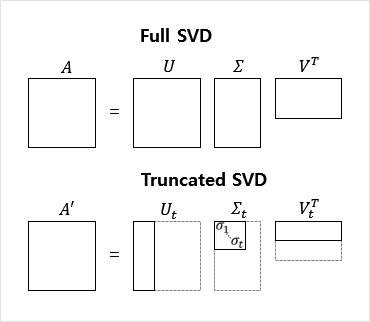
    - 특이값 분해는 고유값분해와 달리 정방 행렬뿐만 아니라 행과 열의 크기가 다른 행려에 대해서도 적용이 가능합니다. 즉, 모든 직각 행렬에 대해 적용이 가능한 것입니다.
    - m x n 크기의 임의의 사각 행렬 A를 위 그림의 Full SVD와 같이 특이 벡터(singular vector)의 행렬과 특잇값(singular value)의 대각행렬로 분해하는 것입니다.
    - 행렬 A에 특잇값 분해를 수행하면 U, Σ, V라는 세 가지 행렬로 분해됩니다.
        - Unitary(U), Orthogonal matrix(V)
        - Diagonal matrix (singularity matrix, 가치있는 순서대로 정렬)
    - SVD로 분해를 했다가 가치가 있어 보이는 특이 값만 가지고 복구합니다. 
    
    - 특이값 분해의 목적
        - 행렬의 크기를 감소시킵니다.
        - 정방행렬이 아닌 행렬의 해를 구할 수 있습니다.
        - 데이터 측면에서 테이터의 크기를 줄입니다.
        
    - 특잇값 가운데 가장 중요한 t개만 남기고 해당 특잇값에 대응되는 특이 벡터(singular vector)들로 행렬 A를 근사(approximate)하도록 하면, 이를 **절단된 특잇값 분해(Truncated SVD)**라고 합니다. 
    - Truncated SVD를 수행하면 행렬 Σ의 대각 원솟값 중에서 상위값 t개만 남게 되며, U행렬과 V행렬의 t열까지만 남습니다.
    - 이로 인해서 세 행렬에서 값(정보)의 손실이 일어나 기존의 행렬 A를 정확히 복구할 수는 없게 됩니다. 
    - t는 사용자가 직접 값을 선택하며 성능에 영향을 주는 매개변수 즉 하이퍼파라미터입니다. t를 크게 잡으면 기존의 행렬 A로부터 다양한 의미를 가져갈 수 있지만, 노이즈를 제거하려면 t를 작게 잡아야 합니다. 
    
- 참고 : [고유값, 고유벡터, 고유값 분해](https://bkshin.tistory.com/entry/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-19-%ED%96%89%EB%A0%AC?category=1057680), [특이값 분해](https://datascienceschool.net/02%20mathematics/03.04%20%ED%8A%B9%EC%9E%87%EA%B0%92%20%EB%B6%84%ED%95%B4.html), [특이값 분해 영상](https://www.youtube.com/watch?v=vxJ1MzfvL5w)

### LSA와 Truncated SVD
- LSA는 DTM이나 TF-IDF행렬 등에 Truncated SVD를 수행합니다. 
- 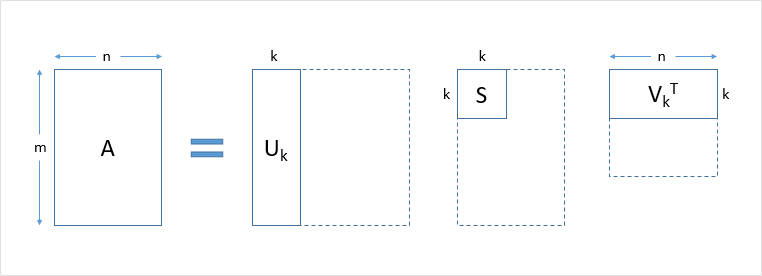
- [출처 : https://www.analyticsvidhya.com/blog/2018/10/stepwise-guide-topic-modeling-latent-semantic-analysis/]
- A = USV<Sup>T</sup>
- 이렇게 분해하여 얻은 행렬 3개는 (U, V, S)는 아래와 같이 해석할 수 있습니다. 
    - U : '문서들과 관련된 의미들을 표현한 행렬'
    - V : '단어들과 관련된 의미를 표현한 행렬'
    - S : '각의미의 중요도를 표현한 행렬'
- 위 Truncated SVD 그림을 살펴봅니다.
    - 하이퍼파라미터 t는 여기서는 k로 표현했습니다.
    - m을 문서의 수, n을 단어의 수라고 할때, Truncated SVD를 통해 얻은 행렬 U_k는 m x k 의 크기를 가집니다. 문서의 수에 해당되는 m의 크기는 줄어들지 않았습니다. 이때 U_k의 각 행은 각 문서를 표현하는 문서 벡터입니다. 
    - 반대로 transpose(V_k)는 k x n의 크기를 가지는 행렬이 됩니다. 단어의 수에 해당되는 n의 크기는 줄어들지 않았습니다. 이 행렬의 각 열은 각 단어를 나타내는 n 차원의 단어벡터가 됩니다. A에서 단어 벡터의 크기는 m 이없는데, transpose(V_k)는 k의 크기를 가지게 되었으므로 벡터의 차원이 저차원으로 축소된 셈입니다. 벡터의 차원을 저차원으로 축소하면서 잠재된 의미를 끌어내는 여러가지 방법은 '워드 임베딩'에서 자세히 다루겠습니다.
    - DTM이나 TF-IDF행렬에 Truncated SVD를 수행하고 얻은 transpose(V_k)행렬의 k열은 전체 코퍼스로부터 얻어낸 k개의 주요 주제(topic)으로 간주할 수 있습니다. 

## 2-2. LSA 실습


### 데이터 로드 및 분석
- abcnews-date-text.csv에는 약 108만개의 샘플이 존재합니다.
- publish_data는 이번 실습에 불필요하므로 headline_text만 별도로 저장합니다. 
- 약 108만개의 샘플 중 중복을 제외하면 약 105만 개의 샘플이 존재합니다. 약 3만개의 중복샘플을 제거합니다. 

In [22]:
import pandas as pd
import numpy as np
import urllib.request
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [23]:
#- nltk 데이터셋 다운로드
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /aiffel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /aiffel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [24]:
#- 데이터 다운로드
import os
csv_filename = os.getenv('HOME')+'/aiffel/topic_modelling/data/abcnews-date-text.csv'

urllib.request.urlretrieve("https://raw.githubusercontent.com/franciscadias/data/master/abcnews-date-text.csv", 
                           filename=csv_filename)

('/aiffel/aiffel/topic_modelling/data/abcnews-date-text.csv',
 <http.client.HTTPMessage at 0x7fe731396f10>)

In [25]:
data = pd.read_csv(csv_filename, error_bad_lines=False)
data.shape

(1082168, 2)

In [26]:
data.head()

,publish_date,headline_text
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit
3,20030219,air nz staff in aust strike for pay rise
4,20030219,air nz strike to affect australian travellers


In [27]:
text = data[['headline_text']].copy()
text.head()

,headline_text
0,aba decides against community broadcasting lic...
1,act fire witnesses must be aware of defamation
2,a g calls for infrastructure protection summit
3,air nz staff in aust strike for pay rise
4,air nz strike to affect australian travellers


In [28]:
text.nunique() #- 중복을 제외하고 유일한 시퀀스를 가지는 샘플의 개수를 출력

headline_text    1054983
dtype: int64

In [30]:
text.drop_duplicates(inplace=True) #- 중복 샘플 제거
text.reset_index(drop=True, inplace=True)
text.shape

(1054983, 1)

### 데이터 정제 및 정규화
- 텍스트 데이터를 정제 및 정규화하는 과정을 진행해봅니다. 
- 우선 NLTK의 토크나이저를 이용해 전체 텍스트 데이터에 대해서 단어 토큰화를 수행하고, NLTK가 제공하는 불용어 리스트를 사용하여 불용어를 제거합니다. 
- 동일한 단어지만 다른 표현을 가지는 단어들을 하나의 단어로 통합(lemmatization)하는 단어 정규화 과정, 그리고 길이가 1-2인 단어를 제거하는 전처리를 진행합니다. 

In [32]:
#- NLTK 토크나이저를 이용해서 토큰화
text['headline_text'] = text.apply(lambda row: nltk.word_tokenize(row['headline_text']), axis=1)

#- 불용어 제거
stop_words = stopwords.words('english')
text['headline_text'] = text['headline_text'].apply(lambda x:[word for word in x if word not in (stop_words)])

text.head()

,headline_text
0,"[aba, decides, community, broadcasting, licence]"
1,"[act, fire, witnesses, must, aware, defamation]"
2,"[g, calls, infrastructure, protection, summit]"
3,"[air, nz, staff, aust, strike, pay, rise]"
4,"[air, nz, strike, affect, australian, travellers]"


In [33]:
#- 단어 정규화. 3인칭 단수 표현 -> 1인칭 변환, 과거형 동사 -> 현재형 동사 등을 수행합니다. 
text['headline_text'] = text['headline_text'].apply(lambda x:[WordNetLemmatizer().lemmatize(word, pos='v') for word in x]) #- v : verb

#- 길이가 1-2인 단어는 제거
text = text['headline_text'].apply(lambda x:[word for word in x if len(word)>2])
print(text[:5])

0     [aba, decide, community, broadcast, licence]
1    [act, fire, witness, must, aware, defamation]
2       [call, infrastructure, protection, summit]
3            [air, staff, aust, strike, pay, rise]
4    [air, strike, affect, australian, travellers]
Name: headline_text, dtype: object


### 역토큰화 및 DTM 생성
- DTM을 생성하는 CountVectorizer또는 TF-IDF 행렬을 생성하는 TfidfVectorizer의 입력으로 사용하기 위해서 토큰화 과정을 역으로 되돌리는 역토큰화(detokenizer)를 수행합니다. 
- DTM의 크기(shape)는 (문서의 수 x 단어집합의 크기) 입니다. 

In [40]:
#- 역토큰화(토큰화 작업을 역으로 수행)
detokenized_doc = []
for i in range(len(text)):
    t = ' '.join(text[i]) #- 리스트의 요소를 공백으로 구분하여 하나의 문자열로 반환
    detokenized_doc.append(t)

train_data = detokenized_doc

In [41]:
train_data[:5]

['aba decide community broadcast licence',
 'act fire witness must aware defamation',
 'call infrastructure protection summit',
 'air staff aust strike pay rise',
 'air strike affect australian travellers']

In [43]:
#- 상위 5000개의 단어만 사용
c_vectorizer = CountVectorizer(stop_words='english', max_features=5000)
document_term_matrix = c_vectorizer.fit_transform(train_data)

In [44]:
print('행렬의 크기:', document_term_matrix.shape)

행렬의 크기: (1054983, 5000)


### scikit-learn Truncated SVD 활용
- Truncated SVD로 LSA를 수행합니다.
- 토픽의 수(k)를 10으로 정해보겠습니다. 
- 행렬 transpose(V_k)가 k x (단어의 수)의 크기를 가지도록 DTM에 TruncatedSVD를 수행합니다. 
- 참고 : [sklearn.decomposition.TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD.fit_transform)

- [np.argsort()](https://numpy.org/doc/stable/reference/generated/numpy.argsort.html)


In [45]:
from sklearn.decomposition import TruncatedSVD

n_topics = 10
lsa_model = TruncatedSVD(n_components = n_topics)
lsa_model.fit_transform(document_term_matrix)

array([[ 1.20378927e-02, -3.71199948e-03,  1.82950767e-02, ...,
         5.47735557e-03, -3.45196582e-03, -5.21924384e-03],
       [ 2.90457315e-02, -1.13388616e-02,  1.82757624e-02, ...,
        -1.41287249e-03,  1.59063756e-02,  8.10307944e-03],
       [ 5.03806337e-03, -1.95242428e-03,  9.73239934e-03, ...,
        -1.32653471e-03, -2.30101858e-03, -6.46719940e-04],
       ...,
       [ 2.97365896e-02,  4.63966242e-03,  2.50654057e-02, ...,
         3.59366393e-02, -2.12813245e-02,  2.38724937e-02],
       [ 6.17758554e-02, -6.17277919e-03,  1.35856388e-01, ...,
         9.99680605e-01, -6.02063810e-01, -3.37730521e-02],
       [ 7.24034855e-02,  3.04347078e-02, -2.12840440e-03, ...,
         4.13492833e-03,  1.37195829e-02,  6.92838047e-02]])

In [46]:
print(lsa_model.components_.shape)

(10, 5000)


In [47]:
terms = c_vectorizer.get_feature_names() # 단어 집합. 5,000개의 단어가 저장되어있습니다.

def get_topics(components, feature_names, n=5):
    for idx, topic in enumerate(components):
        print("Topic %d:" % (idx+1), [(feature_names[i], topic[i].round(5)) for i in topic.argsort()[:-n - 1:-1]])
get_topics(lsa_model.components_, terms)

Topic 1: [('police', 0.74636), ('man', 0.45356), ('charge', 0.21083), ('new', 0.14089), ('court', 0.11139)]
Topic 2: [('man', 0.69419), ('charge', 0.30046), ('court', 0.16802), ('face', 0.11461), ('murder', 0.10568)]
Topic 3: [('new', 0.83666), ('plan', 0.23639), ('say', 0.1826), ('govt', 0.1107), ('council', 0.10976)]
Topic 4: [('say', 0.73704), ('plan', 0.35811), ('govt', 0.1659), ('council', 0.13552), ('fund', 0.07668)]
Topic 5: [('plan', 0.73512), ('council', 0.17137), ('govt', 0.14015), ('urge', 0.08578), ('water', 0.06607)]
Topic 6: [('govt', 0.55481), ('urge', 0.25886), ('court', 0.24172), ('fund', 0.1846), ('face', 0.17405)]
Topic 7: [('charge', 0.50947), ('court', 0.45954), ('face', 0.34738), ('murder', 0.12237), ('plan', 0.11493)]
Topic 8: [('win', 0.65111), ('court', 0.29304), ('kill', 0.21079), ('australia', 0.14522), ('crash', 0.12573)]
Topic 9: [('court', 0.56782), ('face', 0.12996), ('accuse', 0.10603), ('govt', 0.1047), ('kill', 0.07878)]
Topic 10: [('kill', 0.51039), (

## 2-3. LDA(Latent Dirichlet Allocation)

- 문서의 집합에서 토픽을 찾아내는 프로세스를 토픽 모델링(Topic Modelling)이라고 합니다. 
- 이는 고객의 소리와 같이 많은 문서에서 주요 주제를 알아내는 일이 중요할 때 사용합니다. 
- 잠재 디리클레 할당(Latent Dirichlet Allocation)은 토픽 모델링의 또 다른 대표적인 알고리즘입니다. 
- 간단히 말하면 LDA는 문서들이 토픽들의 혼합으로 구성되어 있으며, 토픽들은 확률 분포에 기반하여 단어들을 생성한다고 가정합니다. 그리고 데이터가 주어지면, LDA는 이 가정에 따라 단어들의 분포로부터 문서가 생성되는 과정을 역추척해 문서의 토픽을 찾아냅니다. 
- LSA는 DTM을 차원 축소하여 축소 차원에서 근접 단어들을 토픽으로 묶는 반면에, LDA는 단어가 특정 토픽에 존재할 확률과 문서에 특정 토픽이 존재할 확률을 결합 확률로 추정하여 토픽을 추출합니다.
- 참고 : [LDA](https://wikidocs.net/30708), [LDA 모형 영상](https://serviceapi.nmv.naver.com/flash/convertIframeTag.nhn?vid=A008B9E1EAFC02C99F92928155487839090E&outKey=V1210ad4156cf64ce0c6a3e18cecaae499f6528784c999ca6541c3e18cecaae499f65&width=544&height=306)

### LDA Simulation
- [LDA Topic Modeling Simulation](https://lettier.com/projects/lda-topic-modeling/)에서는 별도의 코드 작성 없이 입력한 문서들로부터 DTM을 만들고 LDA를 수행한 결과를 보여주는 웹 사이트입니다. 
- Add Document, Topics지정, Run LDA 순서로 시뮬레이션을 진행해봅니다. 
- 시뮬레이션의 결과, 첫번째 행렬에서 행은 단어 집합의 단어들이고, 열은 Topic입니다. 두번째 행렬에서 행은 문서이고 열은 Topic입니다.

### LDA의 두가지 결과
- LDA는 각 토픽의 단어 분포와 각 문서의 토픽 문포를 추정해냅니다.
- 각 토픽의 단어 분포, 즉 특정 토픽에 특정 단어가 나타날 확률을 추정합니다.
- 단어들의 분포로부터 해당 문서의 토픽 분포를 추정합니다.

### LDA의 가정
- LDA는 전체 코퍼스, 즉 다수의 문서들로부터 토픽을 뽑아내기 위해서 하나의 가정을 염두에 두고 있습니다. 
- 모든 문서 하나, 하나가 작성될 때 그 문서의 작서자는 아래와 같은 생각을 했다는 가정입니다. "나는 이 문서를 작성하기 위해 이러한 주제들을 넣을거고, 이러한 주제들을 위해서는 이러한 단어들을 넣을거야"

## 2-4. LDA 실습
- LDA 실습은 LSA 실습 과정에서 만들어둔 전처리가 완료된 train_data를 재사용한다고 가정합니다. 해당 데이터는 역토큰화 과정을 거친 데이터입니다.

### TF-IDF 행렬 생성
- LDA는 DTM 또는 TF-IDF를 입력으로 받을 수 있습니다. 이번에는 TF-IDF를 사용하겠습니다. 

In [51]:
#- 상위 5,000개의 단어만 사용
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
tf_idf_matrix = tfidf_vectorizer.fit_transform(train_data)

#- TF-IDF 행렬의 크기를 확인합니다.
print('행렬의 크기:', tf_idf_matrix.shape)

행렬의 크기: (1054983, 5000)


### sckit-learn LDA Model 활용 
- 사이킷런의 LDA 모델을 사용하여 학습합니다. 
- 토픽의 개수(n_components)는 10개로 정했습니다. 

In [52]:
from sklearn.decomposition import LatentDirichletAllocation 

lda_model = LatentDirichletAllocation(n_components=10, learning_method='online', random_state=0, max_iter=1)
lda_model.fit_transform(tf_idf_matrix)

array([[0.0335099 , 0.0335099 , 0.69841093, ..., 0.0335099 , 0.0335099 ,
        0.0335099 ],
       [0.03365631, 0.03365631, 0.03365631, ..., 0.03365631, 0.03365631,
        0.03365631],
       [0.67051361, 0.0366096 , 0.0366096 , ..., 0.0366096 , 0.0366096 ,
        0.0366096 ],
       ...,
       [0.02914502, 0.02914502, 0.02914502, ..., 0.39250986, 0.02914502,
        0.24170159],
       [0.02637829, 0.29529958, 0.02637829, ..., 0.02637923, 0.02637829,
        0.02637829],
       [0.2116987 , 0.03376055, 0.03376055, ..., 0.03376055, 0.03376055,
        0.03376055]])

In [53]:
print(lda_model.components_.shape)

(10, 5000)


In [54]:
terms = tfidf_vectorizer.get_feature_names() # 단어 집합. 5,000개의 단어가 저장되어있습니다.

def get_topics(components, feature_names, n=5):
    for idx, topic in enumerate(components):
        print("Topic %d:" % (idx+1), [(feature_names[i], topic[i].round(5)) for i in topic.argsort()[:-n - 1:-1]])
get_topics(lda_model.components_, terms)

Topic 1: [('live', 3625.10473), ('rural', 3521.57361), ('plan', 3192.97344), ('hour', 3124.27779), ('new', 3044.92924)]
Topic 2: [('south', 4846.36922), ('report', 3796.18865), ('face', 3609.78317), ('court', 3213.13421), ('health', 3166.2276)]
Topic 3: [('australian', 7667.75984), ('charge', 5946.75895), ('murder', 4678.19303), ('man', 4127.09542), ('die', 4025.52753)]
Topic 4: [('australia', 9359.93155), ('say', 7619.56665), ('queensland', 5552.50636), ('north', 3706.11793), ('warn', 3577.31092)]
Topic 5: [('world', 4536.54896), ('house', 4481.7693), ('country', 4167.71985), ('2016', 3955.96022), ('hit', 3572.3951)]
Topic 6: [('melbourne', 5299.84238), ('death', 4282.28504), ('day', 4243.05896), ('kill', 4093.711), ('sydney', 3748.17169)]
Topic 7: [('trump', 8187.32777), ('new', 5728.61917), ('election', 5419.59533), ('canberra', 4323.24003), ('win', 4318.12702)]
Topic 8: [('year', 3924.88995), ('state', 3658.17038), ('women', 3029.28981), ('league', 2850.22864), ('fall', 2659.83801)

# 3. 텍스트 분포를 이용한 비지도 학습 토크나이저
## 3-1. 형태소 분석기와 단어 미등록 문제
- 지금까지 띄어쓰기 단위의 단어 분포를 이용해서 단어나 문서를 벡터화하는 방법에 대해 알아봤습니다. 이번에는 텍스트의 분포를 이용해서 토큰화를 수행하는 비지도 학습 토크나이저에 대해서 알아봅니다. 

### 형태소 분석기의 필요성
- 한국어는 교착어입니다. 교착어란 하나의 낱말(엄밀히는 하나의 어절)이 하나의 어근(root)(혹은 어간(stem))과 각각 단일한 기능을 가지는 하나 이상의 접사(affix)의 결합으로 이뤄져 있는 언어를 말합니다. 조사라는 품사는 교착어에서만 존재합니다. 
- 이러한 특성으로 인해 한국어는 영어와 달리 조사나 접사가 존재하며, 영어처럼 띄어쓰기 단위 토큰화가 제대로 동작하지 않습니다. 


In [55]:
en_text = "The dog ran back to the corner near the spare bedrooms"
print(en_text.split())

['The', 'dog', 'ran', 'back', 'to', 'the', 'corner', 'near', 'the', 'spare', 'bedrooms']


In [58]:
kor_text = "나는 고소한 아보카도를 좋아해. 아보카도는 동그란 씨앗을 남기는데, 오징어땅콩을 닮았어. 나는 항상 아보카도의 씨앗을 버리지 않고, 물에 담가서 싹을 틔워. 그리고 흙으로 옮겨주면 무럭무럭 자라나. 얘네들 이름은 오징어땅콩, 줄여서 '오땅'이야."
print(kor_text.split())

['나는', '고소한', '아보카도를', '좋아해.', '아보카도는', '동그란', '씨앗을', '남기는데,', '오징어땅콩을', '닮았어.', '나는', '항상', '아보카도의', '씨앗을', '버리지', '않고,', '물에', '담가서', '싹을', '틔워.', '그리고', '흙으로', '옮겨주면', '무럭무럭', '자라나.', '얘네들', '이름은', '오징어땅콩,', '줄여서', "'오땅'이야."]


- 위의 예제 문장에서 아보카도란 단어가 총 3번 등장하는데, '를','는','의' 등이 붙어있게 됩니다. 이를 제거해주지 않으면, 기계는 전부 다른 단어로 인식하게 되는 것입니다. 
- 이를 해결하기 위해서 한국어는 주로 형태소 분석기를 사용합니다. 예를 들어, 형태소 분석기 중 하나인 Okt를 사용하면 다음과 같은 결과를 얻습니다. 

In [59]:
from konlpy.tag import Okt

tokenizer = Okt()
print(tokenizer.morphs(kor_text))

['나', '는', '고소한', '아보카도', '를', '좋아해', '.', '아보카도', '는', '동그란', '씨앗', '을', '남기는데', ',', '오징어', '땅콩', '을', '닮았어', '.', '나', '는', '항상', '아보카도', '의', '씨앗', '을', '버리지', '않고', ',', '물', '에', '담가서', '싹', '을', '틔워', '.', '그리고', '흙', '으로', '옮겨주면', '무럭무럭', '자라나', '.', '얘', '네', '들', '이름', '은', '오징어', '땅콩', ',', '줄', '여서', "'", '오', '땅', "'", '이야', '.']


### 단어 미등록 문제
- 하지만 기존의 형태소 분석기는 등록된 단어를 기준으로 형태소를 분류해 내어, 새롭게 만들어진 단어를 인식하기 어렵다는 특징이 있습니다. 
- 아래 예제에서 '모두의연구소'는 하나의 단어이지만 형태소 분석 결과에서 분리된 결과를 보입니다. 
- 그렇다면 텍스트 데이터에서 특정 문자 시퀀스가 함께 자주 등장하는 빈도 높고, 앞뒤로 조사 또는 완전히 다른 단어가 등장하는 것을 고려해서 해당 문자 시퀀스를 형태소라고 판단하는 형태소 분석기는 어떨까요? 

- 예를 들어 '모두의연구소'라는 문자열이 자주 연결되어 등장한다면 형태소라고 판단하고, 모두의연구소'라는 단어 앞, 뒤에 '최고', 'AI', '실력'과 같은 독립된 다른 단어들이 계속해서 등장한다면 '모두의연구소'를 형태소로 파악하는 것입니다. 
- 이러한 아이디어를 가진 형태소 분석기가 바로 soynlp입니다.

In [60]:
print(tokenizer.morphs('모두의연구소에서 자연어 처리를 공부하는 건 정말 즐거워'))

['모두', '의', '연구소', '에서', '자연어', '처리', '를', '공부', '하는', '건', '정말', '즐거워']


## 3-2. soynlp
- soynlp는 품사 태깅, 형태소 분석 등을 지원하는 한국어 형태소 분석기입니다
- 비지도 학습으로 형태소 분석을 한다는 특징을 갖고 있으며, 데이터에 자주 등장하는 단어들을 형태소로 분석합니다.
- soynlp 형태소 분석기는 내부적으로 단어 점수표로 동작합니다. 이 점수는 응집 확률(cohesion probability) 과 브랜칭 엔트로피(branching entropy) 를 활용합니다.

### soynlp의 응집 확률(cohesion probability)
- 응집 확률은 내부 문자열(substring)이 얼마나 응집하여 자주 등장하는지를 판단하는 척도입니다. 
- 응집 확률은 문자열을 문자 단위로 분리하여 내부 문자열을 만드는 과정에서, 왼쪽부터 순서대로 문자를 추가하면서 각 문자열이 주어졌을 때 그다음 문자가 나올 확률을 계산하여 누적 곱을 한 값입니다. 
- 이 값이 높을수록 전체 코퍼스에서 이 문자열 시퀀스는 하나의 단어로 등장할 가능성이 높습니다.
- 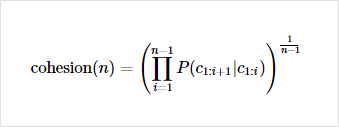

### soynlp의 브랜칭 엔트로피(branching entropy)
- 브랜칭 엔트로피(Branching Entropy) 는 확률 분포의 엔트로피값을 사용합니다. 이는 주어진 문자열에서 다음 문자가 등장할 수 있는 가능성을 판단하는 척도입니다.
- 브랜칭 엔트로피를 주어진 문자 시퀀스에서 다음 문자 예측을 위해 헷갈리는 정도라고 비유할 수 있습니다. 브랜칭 엔트로피의 값은 하나의 완성된 단어에 가까워질수록 문맥으로 인해 정확히 예측할 수 있게 되므로 점차 줄어듭니다. 

### soynlp의 LTokenizer
- 띄어쓰기 단위로 잘 나뉜 문장은 L 토크나이저(LTokenizer)를 사용하면 좋습니다.
- 한국어는 띄어쓰기 단위로 나눈 어절 토큰이 주로 L 토큰 + R 토큰의 형식을 가질 때가 많습니다. 예를 들어서 '공원에'는 '공원 + 에'로 나눌 수 있겠지요. 또는 '산책하는'은 '공부 + 하는'으로 나눌 수도 있을 것입니다. L 토크나이저는 L 토큰 + R 토큰으로 나누되, 점수가 가장 높은 L 토큰을 찾아내는 분리 기준을 가지고 있습니다.

### 최대 점수 토크나이저
- 최대 점수 토크나이저(MaxScoreTokenizer)는 띄어쓰기가 되어 있지 않은 문장에서 점수가 높은 글자 시퀀스를 순차적으로 찾아내는 토크나이저입니다.


## 3-3. soynlp 실습
- soynlp 깃허브에서 제공하는 예제 말뭉치를 다운로드합니다.
- 다운로드 한 말뭉치를 문서 단위로 분리합니다. 
- 총 30,091개의 문서가 존재합니다. 공백이 아닌 문서에 한해 상위 3개의 문서만 출력해봅니다. 
- soynlp는 비지도학습 형태소 분석기이므로 기존의 형태소 분석기와는 달리 학습 과정을 거쳐야 합니다. 
- 전체 코퍼스로부터 응집 확률과 브랜칭 엔트로피 단어 점수표를 만드는 과정입니다. WordExtractor.extract()를 통해서 전체 코퍼스에 대해 단어 점수표를 계산할 수 있습니다. 


In [61]:
import urllib.request

txt_filename = os.getenv('HOME')+'/aiffel/topic_modelling/data/2016-10-20.txt'

urllib.request.urlretrieve("https://raw.githubusercontent.com/lovit/soynlp/master/tutorials/2016-10-20.txt",\
                            filename=txt_filename)

('/aiffel/aiffel/topic_modelling/data/2016-10-20.txt',
 <http.client.HTTPMessage at 0x7fe7245fddd0>)

In [62]:
from soynlp import DoublespaceLineCorpus

#- 말뭉치에 대해서 다수의 문서로 분리
corpus = DoublespaceLineCorpus(txt_filename)
len(corpus)

30091

In [63]:
i = 0
for document in corpus:
    if len(document) > 0:
        print(document)
        i = i+1
    if i == 3:
        break

19  1990  52 1 22
오패산터널 총격전 용의자 검거 서울 연합뉴스 경찰 관계자들이 19일 오후 서울 강북구 오패산 터널 인근에서 사제 총기를 발사해 경찰을 살해한 용의자 성모씨를 검거하고 있다 성씨는 검거 당시 서바이벌 게임에서 쓰는 방탄조끼에 헬멧까지 착용한 상태였다 독자제공 영상 캡처 연합뉴스  서울 연합뉴스 김은경 기자 사제 총기로 경찰을 살해한 범인 성모 46 씨는 주도면밀했다  경찰에 따르면 성씨는 19일 오후 강북경찰서 인근 부동산 업소 밖에서 부동산업자 이모 67 씨가 나오기를 기다렸다 이씨와는 평소에도 말다툼을 자주 한 것으로 알려졌다  이씨가 나와 걷기 시작하자 성씨는 따라가면서 미리 준비해온 사제 총기를 이씨에게 발사했다 총알이 빗나가면서 이씨는 도망갔다 그 빗나간 총알은 지나가던 행인 71 씨의 배를 스쳤다  성씨는 강북서 인근 치킨집까지 이씨 뒤를 쫓으며 실랑이하다 쓰러뜨린 후 총기와 함께 가져온 망치로 이씨 머리를 때렸다  이 과정에서 오후 6시 20분께 강북구 번동 길 위에서 사람들이 싸우고 있다 총소리가 났다 는 등의 신고가 여러건 들어왔다  5분 후에 성씨의 전자발찌가 훼손됐다는 신고가 보호관찰소 시스템을 통해 들어왔다 성범죄자로 전자발찌를 차고 있던 성씨는 부엌칼로 직접 자신의 발찌를 끊었다  용의자 소지 사제총기 2정 서울 연합뉴스 임헌정 기자 서울 시내에서 폭행 용의자가 현장 조사를 벌이던 경찰관에게 사제총기를 발사해 경찰관이 숨졌다 19일 오후 6시28분 강북구 번동에서 둔기로 맞았다 는 폭행 피해 신고가 접수돼 현장에서 조사하던 강북경찰서 번동파출소 소속 김모 54 경위가 폭행 용의자 성모 45 씨가 쏜 사제총기에 맞고 쓰러진 뒤 병원에 옮겨졌으나 숨졌다 사진은 용의자가 소지한 사제총기  신고를 받고 번동파출소에서 김창호 54 경위 등 경찰들이 오후 6시 29분께 현장으로 출동했다 성씨는 그사이 부동산 앞에 놓아뒀던 가방을 챙겨 오패산 쪽으로 도망간 후였다  김 경위는 오패산 터널 입구 오른쪽의 급경사에서 성씨에

In [64]:
from soynlp.word import WordExtractor

word_extractor = WordExtractor()
word_extractor.train(corpus)
word_score_table = word_extractor.extract()

training was done. used memory 2.810 Gb
all cohesion probabilities was computed. # words = 223348
all branching entropies was computed # words = 361598
all accessor variety was computed # words = 361598


### soynlp의 응집확률

- 응집 확률이 최대화가 되는 내무 문자열 구간은 '여의도한강공원'입니다. 다시말하면 '여의도한강공원'이 하나의 단어일 확률이 높은 것입니다.

In [66]:
word_score_table["여의도한"].cohesion_forward

0.0640621810396485

In [67]:
word_score_table["여의도한강"].cohesion_forward

0.12733602552300902

In [68]:
word_score_table["여의도한강공"].cohesion_forward

0.19229191842663287

In [69]:
word_score_table["여의도한강공원"].cohesion_forward

0.2531050790475144

### soynlp의 브랜칭 엔트로피
- '디스' 다음에는 다양한 문자가 올 수 있으니까 1.63이라는 값을 가지는 반면, '디스플'이라는 문자열 다음에는 다음 문자로 '레'가 오는 것이 너무나 명백하기 때문에 0이란 값을 가집니다.
- 그런데 '디스플레이'의 값은 급증하는데, 문자 시퀀스 '디스플레이'라는 문자 시퀀스 다음에는 조사나 다른 단어가 나올 수 있는 다양한 경우가 있을 수 있기 때문입니다.
- 즉 하나의 단어가 끝나면 그 경계 부분부터 다시 브랜칭 엔트로피값이 증가함을 의미합니다.

In [70]:
word_score_table["디"].right_branching_entropy

2.68517802819071

In [71]:
word_score_table["디스"].right_branching_entropy

1.6371694761537934

In [72]:
word_score_table["디스플"].right_branching_entropy

-0.0

In [73]:
word_score_table["디스플레"].right_branching_entropy

-0.0

In [74]:
word_score_table["디스플레이"].right_branching_entropy

3.1400392861792916

### soynlp의 LTokenizer


In [77]:
from soynlp.tokenizer import LTokenizer

scores = {word:score.cohesion_forward for word, score in word_score_table.items()}
l_tokenizer = LTokenizer(scores=scores)
l_tokenizer.tokenize("우리가 자주가던 그 공원에 강아지공원이 생겼더라. 강아지공원에는 온세상 강아지들이 다 모여서 뛰놀고 있었어. 당연히 오늘 아침에도 강아지공원을 방문했지.", flatten=False)

[('우리', '가'),
 ('자주가던', ''),
 ('그', ''),
 ('공원에', ''),
 ('강아지', '공원이'),
 ('생겼더라.', ''),
 ('강아지', '공원에는'),
 ('온세상', ''),
 ('강아지들', '이'),
 ('다', ''),
 ('모여서', ''),
 ('뛰놀고', ''),
 ('있었어.', ''),
 ('당연히', ''),
 ('오늘', ''),
 ('아침에도', ''),
 ('강아지', '공원을'),
 ('방문', '했지.')]

### 최대 점수 토크나이저

In [78]:
from soynlp.tokenizer import MaxScoreTokenizer

maxscore_tokenizer = MaxScoreTokenizer(scores=scores)
maxscore_tokenizer.tokenize("우리가자주가던그공원에강아지공원이생겼더라.강아지공원에는온세상강아지들이다모여서뛰놀고있었어.당연히오늘아침에도강아지공원을방문했지.")

['우리',
 '가자주가던그공원에',
 '강아지',
 '공원이생겼더라.',
 '강아지',
 '공원에는온',
 '세상',
 '강아지들',
 '이다모여서',
 '뛰놀고',
 '있었어.',
 '당연히',
 '오늘',
 '아침에도',
 '강아지',
 '공원을',
 '방문',
 '했지.']